In [57]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Setup

In [59]:
from draftbot import AnalyticTableConstructor

atc = AnalyticTableConstructor(db_path="../data/m20/drafts.sqlite")
X, y, y_names_mapping = atc.make_analytic_base_table()

In [60]:
X.head()

options_cavalier_of_dawn  \
draft_id                             drafter pick_number                             
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                                   1   
                                             1                                   0   
                                             2                                   0   
                                             3                                   0   
                                             4                                   0   

                                                          options_ancestral_blade  \
draft_id                             drafter pick_number                            
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                                  0   
                                             1                                  1   
                                             2                                  0   
                                             3                                  0   
                                             4                                  0   

                                                          options_fencing_ace  \
draft_id                             drafter pick_number                        
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                              0   
                                             1                              1   
                                             2                              0   
                                             3                              0   
                                             4                              0   

                                                          options_pacifism  \
draft_id                             drafter pick_number                     
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                           1   
                                             1                           0   
                                             2                           0   
                                             3                           0   
                                             4                           0   

                                                          options_raise_the_alarm  \
draft_id                             drafter pick_number                            
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                                  1   
                                             1                                  0   
                                             2                                  1   
                                             3                                  0   
                                             4                                  1   

                                                          options_griffin_protector  \
draft_id                             drafter pick_number                              
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                                    0   
                                             1                                    0   
                                             2                                    0   
                                             3                                    1   
                                             4                                    0   

                                                          options_inspiring_captain  \
draft_id                             drafter pick_number                              
9aefe0d5-be93-41dc-b6fb-a77a5dbc0faa 0       0                                    0   
                                             1                                    0   
                                             2                                    0   
                                             3                                    0   
                

In [61]:
N_TRAINING = int(2 * X.shape[0] / 3)

train = TensorDataset(
    torch.from_numpy(X[:N_TRAINING].values.astype(np.float32)),
    torch.from_numpy(y[:N_TRAINING].values))
test = TensorDataset(
    torch.from_numpy(X[N_TRAINING:].values.astype(np.float32)),
    torch.from_numpy(y[N_TRAINING:].values))

train_batcher = DataLoader(train, batch_size=42*25)
test_batcher = DataLoader(test, batch_size=42*25)

In [62]:
X.shape

(1680000, 96)

## Load and Fit the Model

In [142]:
from draftbot import DraftBotModel, DraftBotModelTrainer, weight_elimination_regularizer, l1_regularizer

In [143]:
N_CARDS = X.shape[1] // 2

draftbot = DraftBotModel(n_cards=N_CARDS,
                         n_archetypes=10,
                         idx_names_mapping=y_names_mapping)

In [144]:
LEARNING_RATE_SCHEDULE = [0.01]*15 + [0.005]*20 + [0.001]*20 + [0.0001]*30

trainer = DraftBotModelTrainer(n_epochs=len(LEARNING_RATE_SCHEDULE), 
                               learning_rate=LEARNING_RATE_SCHEDULE,
                               loss_function=torch.nn.NLLLoss())

trainer.fit(draftbot, train_batcher, test_batcher=test_batcher)

Training loss, epoch 0: 1.3862345810794563
Testing loss, epoch 0: 0.908059688208255
Training loss, epoch 1: 0.6973103492642074
Testing loss, epoch 1: 0.5407640327340208
Training loss, epoch 2: 0.46399930856891514
Testing loss, epoch 2: 0.4045532867591479
Training loss, epoch 3: 0.3702018677126948
Testing loss, epoch 3: 0.33988277921069426
Training loss, epoch 4: 0.320066415045791
Testing loss, epoch 4: 0.3009629227807013
Training loss, epoch 5: 0.2877225666232721
Testing loss, epoch 5: 0.2740951415695501
Training loss, epoch 6: 0.26443575884040094
Testing loss, epoch 6: 0.2539524876334694
Training loss, epoch 7: 0.24650104550580165
Testing loss, epoch 7: 0.23803321311201495
Training loss, epoch 8: 0.23206258470920502
Testing loss, epoch 8: 0.22498751283808147
Training loss, epoch 9: 0.22007083969632374
Testing loss, epoch 9: 0.21401103608282318
Training loss, epoch 10: 0.20987868772674748
Testing loss, epoch 10: 0.2045888500881106
Training loss, epoch 11: 0.20106094435988572
Testing lo

Text(0, 0.5, 'Log-Loss')

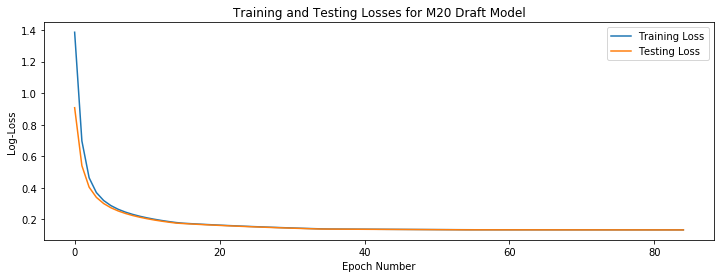

In [145]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(np.arange(trainer.n_epochs), trainer.epoch_training_losses, label="Training Loss")
ax.plot(np.arange(trainer.n_epochs), trainer.epoch_testing_losses, label="Testing Loss")
ax.legend()

ax.set_title("Training and Testing Losses for M20 Draft Model")
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Log-Loss")

### Plot Results

In [146]:
weights_df = pd.DataFrame(draftbot.weights.detach().numpy(),
                          index=y_names_mapping.values())

In [147]:
weights_df.T.to_json('../data/m20/m20-fit-weights.json')

Text(0.5, 1.0, 'Card Archetype Weights')

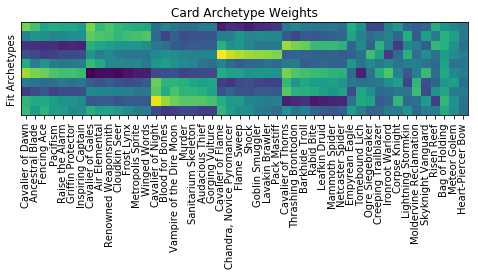

In [162]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(weights_df.T)

ax.set_yticks([], [])
ax.set_ylabel("Fit Archetypes")
ax.set_xticks(np.arange(len(weights_df)))
ax.set_xticklabels(weights_df.index, rotation='vertical')
ax.set_title("Card Archetype Weights")

Text(0.5, 1.0, 'Total Cards Weights')

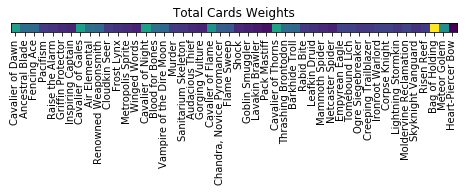

In [163]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(weights_df.sum(axis=1).values.reshape(1, -1))

ax.set_xticks(np.arange(len(weights_df)))
ax.set_xticklabels(weights_df.index, rotation='vertical')
ax.set_yticks([], [])
ax.set_title("Total Cards Weights")

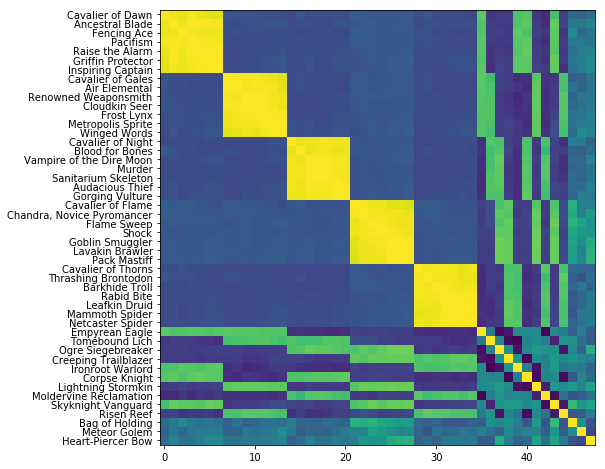

In [169]:
fig, ax = plt.subplots(figsize=(8, 8))

corr = weights_df.T.corr()
max_corr, min_corr = np.max(corr.values), np.min(corr.values)
ax.imshow(corr)

ax.set_yticks(np.arange(len(weights_df)))
_ = ax.set_yticklabels(weights_df.index)

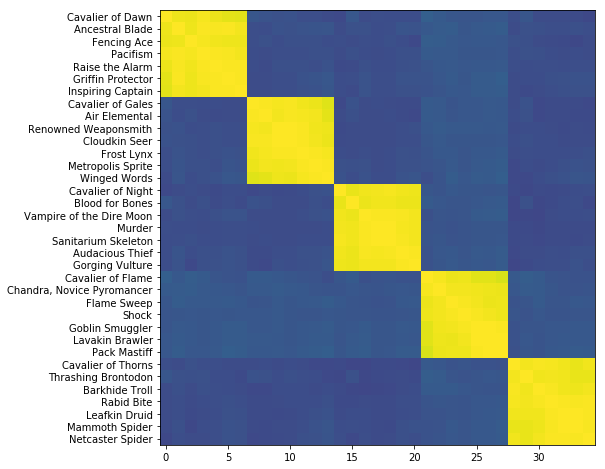

In [170]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(corr.iloc[:(7*5), :(7*5)].values, vmin=min_corr, vmax=max_corr)

ax.set_yticks(np.arange(7*5))
_ = ax.set_yticklabels(weights_df.index[:7*5])

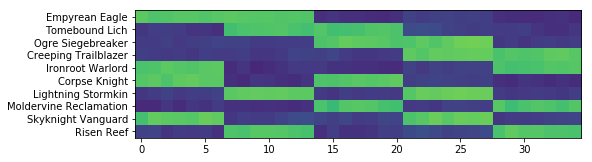

In [171]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(corr.iloc[(7*5):(7*5 + 10), :(7*5)].values, vmin=min_corr, vmax=max_corr)

ax.set_yticks(np.arange(10))
_ = ax.set_yticklabels(weights_df.index[(7*5):(7*5 + 10)])

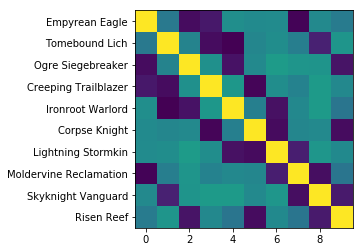

In [172]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(corr.iloc[(7*5):(7*5 + 10), (7*5):(7*5 + 10)].values, vmin=min_corr, vmax=max_corr)

ax.set_yticks(np.arange(10))
_ = ax.set_yticklabels(weights_df.index[(7*5):(7*5 + 10)])

In [176]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [177]:
mds = MDS(2)

mds.fit(weights_df.values)

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0)

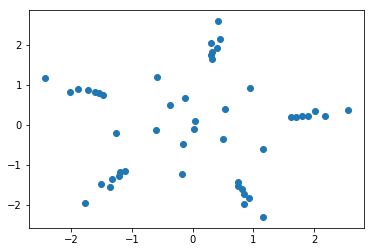

In [179]:
x, y = mds.fit_transform(weights_df.values).T
plt.scatter(x, y)

In [180]:
u, s, v = np.linalg.svd(weights_df.values)

In [181]:
u.shape

(48, 48)

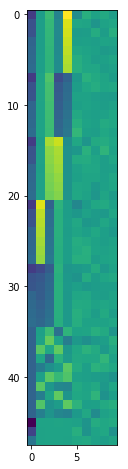

In [182]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow((u[:, :10] @ np.diag(s)))